## Analyze degenerate barcodes
20221006 - Meant to be run after processing of unmapped reads (generated by CellRanger) using Picard / Samtools

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pysam
import scipy.stats

from Bio import SeqIO

np.random.seed(5)

In [2]:
hashes = {}
import csv
with open('barcodes.csv') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    #first column forward, second column reverse complement
    for row in csvreader:
        if row[0].startswith("#"): continue
        hashes[row[0]] = row[2]

In [3]:
hashes

{'TGTCTAGT': 'shRenilla-1',
 'CTGAATCT': 'Myc (63)',
 'TTAATTAG': 'Onecut2 (76)',
 'CGGGAATG': 'Fosl2 (60)',
 'GCCTACGT': 'Fhl2 (61)',
 'GCCAATCG': 'Itga2 (1811)',
 'CGTTTCCT': 'Cldn4 (1999)',
 'ACACGTGA': 'Lif (2114)',
 'CAGTGCAT': 'Nfkb1 (2118)',
 'CGTTAGGG': 'Yap1 (65)',
 'CGTTCAAG': 'Nfkb2 (71)',
 'GGTAGGGA': 'Fosl1 (2115)',
 'ACAGAGCC': 'Relb (73) ',
 'GTACTTGC': 'patch4.4-1',
 'CCATTACT': 'patch4.4-2',
 'CATAGTCA': 'shRenilla-2',
 'TCTGGGGC': 'Atf4 (67)'}

In [4]:
#hashes = {"TGTCTAGT": "shRenilla", "CTGAATCT": "shMyc(63)", "TTAATTAG": "shOnecut2(76)"}
hashmatch = re.compile('GT[ATCG]{5}AA[ATCG]{5}TT[ATCG]{5}AA') #forward
#hashmatch = re.compile('TT[ATCG]{5}AA[ATCG]{5}TT[ATCG]{5}AC') #reverse complement

In [5]:
def hammingDistance(a, b):
    return sum(str1 != str2 for str1, str2 in zip(a, b))

In [6]:
#Changed this to actual experimental whitelist
import pickle
whitelist = set()
#open whitelist
with open('../write/cellwhitelist0.pickle', 'rb') as f:
    whitelist = pickle.load(f)

In [7]:
print(len(whitelist))

7114


In [8]:
afile = pysam.AlignmentFile("./final.bam")
hashcount = {}
hashset = {}
cellhash = {}
taghash = {}
readcount = {}
barcodehash = {} # barcodes listing shRNAID
barcodebycellUMI = {} # barcode listing cellUMI
doublecounts = 0
cellbyUMI = {}
inwhitelist = set()
inwhitelistcount = 0
outwhitelist = set()
outwhitelistcount = 0
for seq_record in afile.fetch(until_eof=True):
    cellUMI = None  # here this is the CellRanger cell UMI
    UMI = None
    if not seq_record.has_tag("CB") or not seq_record.has_tag("UB"): continue
    cellUMI = seq_record.get_tag("CB")
    if cellUMI not in whitelist: 
        outwhitelistcount +=1
        if cellUMI not in outwhitelist: outwhitelist.add(cellUMI)
        continue
    else:
        inwhitelistcount += 1
        if cellUMI not in inwhitelist: inwhitelist.add(cellUMI)
    UMI = seq_record.get_tag("UB") # umi barcode
    
    m = hashmatch.search(seq_record.query_sequence)
    if m == None or (m.end() + 8) > len(seq_record.query_sequence):
        #print("Error, match not found")
        continue
    shRNAID = seq_record.query_sequence[m.end():m.end()+8]
    barcode = seq_record.query_sequence[m.end()-21:m.end()]
    sbID = (shRNAID,barcode)
    if shRNAID not in hashes: continue
    if cellUMI not in cellbyUMI:
        cellbyUMI[cellUMI] = {}
    if UMI not in cellbyUMI[cellUMI]:
        cellbyUMI[cellUMI][UMI] = {sbID: 1}
        continue
    if sbID in cellbyUMI[cellUMI][UMI]:
        cellbyUMI[cellUMI][UMI][sbID] += 1
    else:
        hamming = False
        for x in cellbyUMI[cellUMI][UMI]:
            if hammingDistance(sbID[1],x[1]) <= 2:
                cellbyUMI[cellUMI][UMI][x] += 1
                hamming = True
                break
        if hamming: continue
        cellbyUMI[cellUMI][UMI][sbID] = 1


In [9]:
totalUMI = 0
for cellUMI in cellbyUMI:
    totalUMI += len(cellbyUMI[cellUMI])
print(totalUMI)

2354222


In [10]:
print("In Whitelist UMI: %d\nOut Whitelist UMI: %d" % (len(inwhitelist), len(outwhitelist)))
print("In Whitelist Reads: %d\nOut Whitelist Reads: %d" % (inwhitelistcount, outwhitelistcount))

In Whitelist UMI: 7113
Out Whitelist UMI: 326626
In Whitelist Reads: 305488840
Out Whitelist Reads: 18407990


In [11]:
import pickle
with open('cellbyUMI.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(cellbyUMI, f, pickle.HIGHEST_PROTOCOL)

In [12]:
import pickle
cellbyUMI = False
with open('cellbyUMI.pickle', 'rb') as f:
    cellbyUMI = pickle.load(f)

## IGNORE THIS

## END IGNORE

In [13]:
from IPython.core.debugger import set_trace

In [14]:
# first pass generate histogram of counts
histogram_of_counts = []
for UMI in cellbyUMI:
    for y in cellbyUMI[UMI]:
        histogram_of_counts.extend(cellbyUMI[UMI][y].values())

By UMI/Cell


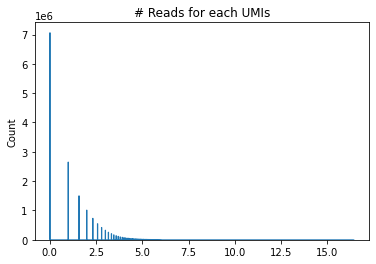

In [15]:
# should only be shRNA per UMI
print("By UMI/Cell")
_ = plt.hist(np.log2(histogram_of_counts), bins='auto', histtype='step')
plt.ylabel("Count")
plt.title("# Reads for each UMIs")
#cutoff = _[1][1]
#plt.axvline(x=cutoff)
plt.show()

In [16]:
_

(array([7.060890e+06, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 2.649795e+06, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.00

In [17]:
count = 0
for x in range(0,len(_[1])):
    if x == 0: continue
    if round(_[1][x]) >= 4:
        count = x
        break

In [18]:
count

192

By UMI/Cell


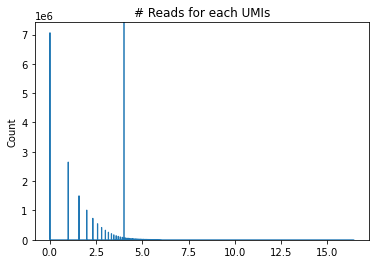

In [19]:
# should only be shRNA per UMI
print("By UMI/Cell")
_ = plt.hist(np.log2(histogram_of_counts), bins='auto', histtype='step')
plt.ylabel("Count")
plt.title("# Reads for each UMIs")
cutoff = round(_[1][count])
plt.axvline(x=cutoff)
plt.show()

In [20]:
cutoff = 2**(round(cutoff))
print(cutoff)

16


In [21]:
# Cleanup, prune any reads that don't pass the cutoff
for UMI in cellbyUMI:
    for y in cellbyUMI[UMI]:
        toRemove = []
        for z in cellbyUMI[UMI][y]:
            if cellbyUMI[UMI][y][z] <= cutoff: toRemove.append(z)
        for z in toRemove:
            del cellbyUMI[UMI][y][z]
    toRemove = []
    for y in cellbyUMI[UMI]:
        if len(cellbyUMI[UMI][y]) == 0: toRemove.append(y)
    for y in toRemove:
        del cellbyUMI[UMI][y]
toRemove = []
for UMI in cellbyUMI:
    if len(cellbyUMI[UMI]) == 0: toRemove.append(UMI)
for UMI in toRemove:
    del cellbyUMI[UMI]

## second pass onwards

## end pass

In [22]:
## counting total UMIs from dominant shRNA
histogram_of_UMIs = []
assignedCellshRNA = {}
assignedCellbarcode = {}
poorUMI = []
poorUMI2 = []
count = []
threshold = cutoff

for x in cellbyUMI:
    ncellbyUMI = {}
    for y in cellbyUMI[x]:
        UMIpairs = [(cellbyUMI[x][y][z],z) for z in cellbyUMI[x][y]] # stored as (count, (shRNAID,barcode))
        UMIpairs.sort(reverse=True)
        newUMI = []
        while len(UMIpairs) != 0:
            shRNAIDbarcodepair = UMIpairs.pop(0) #
            toDelete = []
            for z in range(0, len(UMIpairs)):
                if shRNAIDbarcodepair[1][0] != UMIpairs[z][1][0]: continue
                if hammingDistance(shRNAIDbarcodepair[1][1],UMIpairs[z][1][1]) <= 2:
                    toDelete.append(z)
                    shRNAIDbarcodepair = (shRNAIDbarcodepair[0]+UMIpairs[z][0],shRNAIDbarcodepair[1])
            newUMI.append(shRNAIDbarcodepair)
            for z in sorted(toDelete, reverse = True):
                del UMIpairs[z]

        if len(newUMI) == 1:
        # uncomment here if we don't want to ignore single counts
            if newUMI[0][0] >= threshold: ncellbyUMI[y] = newUMI[0][1]
            continue

        # Shouldn't happen anymore with the cleaned up version
        newUMI.sort(reverse=True)
  
        totalUMI = sum([z[0] for z in newUMI])
        if scipy.stats.binom_test(newUMI[0][0], totalUMI, 1/len(newUMI), alternative='greater') <= 0.05:
            ncellbyUMI[y] = newUMI[0][1]       
        else:
            print(newUMI)
        #### end
        
    UMIpairs = {}

    if len(ncellbyUMI) == 0: 
        print("is zero")
        continue            
            
#    if len(ncellbyUMI) == 1:
#        continue
        # uncomment here if we don't want to ignore UMIs assigned by single counts
        #assignedCellshRNA[x] = list(ncellbyUMI.values())[0][0]
        #assignedCellbarcode[x] = list(ncellbyUMI.values())[0][1]
        #count.append(1)

        #adding single UMIs to poorUMI list instead of assigning label
#        poorUMI.append([(1,ncellbyUMI)])
#        poorUMI2.append(x)
#        continue

    for y in ncellbyUMI:   #ncellbyUMI[UMI] = (shRNAID, barcode)
        if ncellbyUMI[y] in UMIpairs:
            UMIpairs[ncellbyUMI[y]] += 1
        else:
            hamming=False
            for z in UMIpairs:  #instead of assigning this randomly I could order it by number of highest read counts
                if z[0] != ncellbyUMI[y][0]: continue
                if hammingDistance(ncellbyUMI[y][1], z[1]) <= 2:
                    UMIpairs[z] += 1
                    hamming=True
                    break
            if hamming: continue
            UMIpairs[ncellbyUMI[y]] = 1
    histogram_of_UMIs.extend(UMIpairs.values())
    continue
    
    
    
#    if len(UMIpairs) == 0: 
#        print("UMIPairs")
#        print(ncellbyUMI)
#        print(cellbyUMI[x])
#        print("error this shoudl not happen")
#        continue

    if len(UMIpairs) == 1 and list(UMIpairs.values())[0] >= 5:
        assignedCellshRNA[x] = list(UMIpairs.keys())[0][0]
        assignedCellbarcode[x] = list(UMIpairs.keys())[0][1]
        count.append(list(UMIpairs.values())[0])
        continue        
    
    newUMI = [(UMIpairs[y], y) for y in UMIpairs]  # UMIpairs[(shRNAID, barcode)] = count
    newUMI.sort()
    newUMI.reverse()
    totalUMI = sum([y[0] for y in newUMI])
    count.extend([z[0] for z in newUMI if z[0] >= 5])

#    set_trace()
    if newUMI[0][0] < 5: continue
    if len(newUMI) == 2: # newUMI = [(count, (shRNAID, barcode)), ...]
        if newUMI[0][0] - newUMI[1][0] >= 3 and newUMI[1][0] <= 3:
            assignedCellshRNA[x] = newUMI[0][1][0]
            assignedCellbarcode[x] = newUMI[0][1][1]
        continue
    if scipy.stats.binom_test(newUMI[0][0], totalUMI, 1/len(newUMI), alternative='greater') <= 0.15:
        assignedCellshRNA[x] = newUMI[0][1][0]
        assignedCellbarcode[x] = newUMI[0][1][1]
        continue
    poorUMI.append(newUMI)
    poorUMI2.append(x)

[(32, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (30, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (29, ('ACACGTGA', 'GGGGGAAGGGGGTTGTGGGAA')), (23, ('TGTCTAGT', 'CCCTCAACCGCCTTCCCCCAA')), (22, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (22, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (19, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (18, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA'))]
[(28, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (24, ('GCCTACGT', 'GGGGGAAGGGGGTTGGGGGAA')), (22, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(26, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (26, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (24, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (23, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (19, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (19, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (18, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (18, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA'))]
[(29, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (25, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (22, ('TGTCTAGT', 'GGGCGAAGGGGGTTGGGGGAA')), (18, (

[(24, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (17, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(28, ('GGTAGGGA', 'TATTAAAATCACTTTTTTAAA')), (21, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (19, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA'))]
[(31, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (31, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (29, ('TGTCTAGT', 'CTCCCAACCCCCTTCCTCCAA')), (21, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (18, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (18, ('CGGGAATG', 'GGGAGAAGGGTGTTGGGGGAA')), (17, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA'))]
[(19, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (17, ('CGTTCAAG', 'CCTGTAAGTCAATTCTTGCAA'))]
[(20, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (17, ('TGTCTAGT', 'GTGTTAATTGTGTTTGTTTAA'))]
[(27, ('TGTCTAGT', 'GTGGGAATTTCATTGGAGGAA')), (22, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (22, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (21, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (21, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (18, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (17,

[(33, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (30, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(25, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (21, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(19, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (19, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (18, ('CAGTGCAT', 'TCCAGAACTATTTTGATCTAA')), (17, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA'))]
[(26, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (21, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (17, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA'))]
[(25, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (23, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (23, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (18, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(25, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (17, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
[(31, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (20, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(32, ('ACACGTGA', 'TGTTTAAGTTTTTTTTTTGAA')), (26, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (17, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA'))]
[(

/Users/chanj2/opt/miniconda3/envs/scanalysis202208/lib/python3.10/site-packages/scipy/stats/_discrete_distns.py:86: RuntimeWarning: divide by zero encountered in _binom_sf
  return _boost._binom_sf(k, n, p)


[(19, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (18, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(25, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA')), (24, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (20, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (20, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (19, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA'))]
[(30, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (30, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA'))]
[(37, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA')), (28, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(36, ('GCCTACGT', 'GGGGGAAGGCGGTTGGGGGAA')), (34, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA')), (32, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (30, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (27, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (22, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (21, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (17, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(33, ('CGGGAATG', 'AAGGAAAGAAAATTAGGCAAA')), (32, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (23, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (22,

[(18, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (18, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(31, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (25, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (21, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
[(26, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (24, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (21, ('GCCTACGT', 'TTCTGAAGGCGTTTTTTTTAA')), (18, ('GCCTACGT', 'GGGGGAAGGGGGTTGGGGGAA')), (17, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA'))]
[(23, ('GCCTACGT', 'TTCTGAAGGCGTTTTTTTTAA')), (22, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (18, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (18, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(27, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (17, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA'))]
[(19, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (17, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(30, ('TTAATTAG', 'GGTTTAATGATGTTTTGATAA')), (26, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(28, ('ACAGAGCC', 'GGTCAAAAGTTGTTTACTTAA')), (26, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (1

[(34, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (33, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (21, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA'))]
[(23, ('CTGAATCT', 'CCCCCAACCCCTTTCCCCCAA')), (18, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(31, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (21, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (20, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(24, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (21, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (20, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (19, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(23, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (18, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA'))]
[(23, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA')), (21, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(33, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (30, ('CGTTAGGG', 'GTAATAATGAGGTTATGCGAA'))]
[(21, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (17, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (17, ('ACACGTGA', 'GGGGTAAATGTTTTGGTTTAA'))]
[(35, ('ACACGTGA', 'GGGGTAAATGTTTTGGTTTAA')), (

[(29, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (25, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (23, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (18, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(28, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (26, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (21, ('TGTCTAGT', 'TTTTTAATTTCTTTTGTTGAA')), (20, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (18, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (17, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA'))]
[(31, ('ACAGAGCC', 'TCGTTAACAGCGTTTTGCTAA')), (19, ('TGTCTAGT', 'TTTTTAATTTCTTTTTTTTAA'))]
[(27, ('CGTTTCCT', 'GGTCTAAGATAGTTGGGTTAA')), (17, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(24, ('CGTTTCCT', 'GGTCTAAGATAGTTGGGTTAA')), (23, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (21, ('CGGGAATG', 'GGGGGAAGGGGGTTGGGGGAA'))]
[(24, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (18, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (17, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(18, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (17, ('TTAATTAG', 'TTTTTAATTTTTTTTTTTTAA'))]
[(1

[(19, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (18, ('CTGAATCT', 'CCCCCAAACCCATTCCCCCAA'))]
[(23, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (18, ('GCCTACGT', 'GGGGGAAGGGGGTTAGGGGAA')), (18, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(27, ('ACACGTGA', 'CCCCCAATGCCATTCCCCCAA')), (25, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (20, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (19, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(29, ('ACACGTGA', 'CCCCCAATGCAATTCCCCCAA')), (19, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA'))]
[(24, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (20, ('ACACGTGA', 'TGTTTAATTTTTTTTTCTGAA')), (18, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA'))]
[(27, ('GGTAGGGA', 'AGAGAAAAGTGTTTGCTTAAA')), (22, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (20, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (19, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA'))]
[(17, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (17, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(27, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (19, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (1

[(22, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (17, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA'))]
[(23, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (21, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (21, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (20, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (17, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (17, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA'))]
[(24, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (17, ('CTGAATCT', 'CCCCCAAACCCATTCCCCCAA'))]
[(28, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (28, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (28, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (27, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (21, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (20, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (20, ('CGGGAATG', 'TTCTCAACGCCTTTATCCCAA')), (17, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (17, ('ACACGTGA', 'TGTTTAAGTTTTTTTTTTGAA'))]
[(21, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (20, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(27, ('CTGAATCT', 'CCCCCAACCCCTTTCCCCCAA')), (24,

[(28, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (26, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (25, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (19, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (19, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (19, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (18, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (18, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA'))]
[(26, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (22, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (21, ('TGTCTAGT', 'AAAAAAAAAAAATTAAAAAAA'))]
[(26, ('TGTCTAGT', 'AAAAAAAAAAAATTAAAAAAA')), (19, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA'))]
[(31, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (30, ('TTAATTAG', 'TTTTTAATTTTTTTTTTTTAA')), (26, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (17, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA'))]
[(34, ('CGGGAATG', 'GGGGGAAGGGGGTTGGGGGAA')), (30, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (24, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (17, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA'))]
[(27, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (26,

[(21, ('TCTGGGGC', 'CGACCAAACAACTTCAAAAAA')), (20, ('TGTCTAGT', 'GGGCGAAGGGGGTTGGGGGAA')), (18, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (18, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(20, ('TCTGGGGC', 'CGACCAAACAACTTCAAAAAA')), (17, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(24, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (21, ('CGGGAATG', 'GGGGGAAGGGGGTTGGGGGAA')), (20, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (19, ('TGTCTAGT', 'TTTTTAATTTCTTTTTTTTAA')), (17, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
[(19, ('TGTCTAGT', 'GGGGGAATTTGGTTGGTTGAA')), (17, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(25, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (24, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (21, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (18, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA'))]
[(35, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (32, ('TGTCTAGT', 'GGGCGAAGGGGGTTGGGGGAA')), (28, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (21, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (19, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA'))]
[(26

[(28, ('TGTCTAGT', 'CATCGAAGGACCTTACGATAA')), (28, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (25, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (23, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (20, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (19, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (17, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (17, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(18, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (18, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA'))]
[(35, ('TGTCTAGT', 'CATCGAAGGACCTTACGATAA')), (26, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(26, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (24, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(20, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (17, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA'))]
[(22, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (21, ('ACACGTGA', 'CCCCCAACCCCATTCCCCCAA')), (20, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (18, ('TGTCTAGT', 'TTTTTAATTTCTTTTTTTTAA'))]
[(20, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (19, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
[(3

[(29, ('CAGTGCAT', 'GTGGAAATGTTATTGGTAGAA')), (29, ('ACAGAGCC', 'GCTTTAATGTTGTTATTAAAA')), (17, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (17, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(26, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (20, ('TTAATTAG', 'TTTTTAATTTTTTTTTTTTAA')), (19, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (18, ('TGTCTAGT', 'GGGGGAATGGGGTTGGGGGAA')), (18, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(21, ('TTAATTAG', 'TTTTTAATTTTTTTTTTTTAA')), (20, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(22, ('TTAATTAG', 'TTTTTAATTTTTTTTTGTTAA')), (18, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
[(30, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (26, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (18, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
[(31, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (27, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (22, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(35, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (29, ('TTAATTAG', 'TTTTTAATTTTTTTTTTTTAA')), (24, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (21

[(31, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (29, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (27, ('CGGGAATG', 'GGGGGAAGGGGGTTGGGGGAA')), (25, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (24, ('ACACGTGA', 'TTTTTAATTTTTTTTTTTTAA')), (18, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (18, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (18, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
[(23, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (23, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA')), (20, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (18, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (17, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA'))]
[(29, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (25, ('CTGAATCT', 'CCCCCAACCCCTTTCCCCCAA')), (22, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
[(25, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (23, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (21, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (21, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA')), (20, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (19, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (18, (

In [23]:
print(len(histogram_of_UMIs))

3364


By UMI/Cell


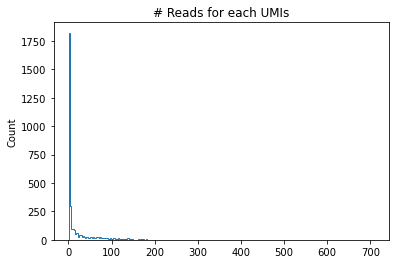

In [24]:
# should only be shRNA per UMI
print("By UMI/Cell")
_ = plt.hist(histogram_of_UMIs, bins='auto', histtype='step')
plt.ylabel("Count")
plt.title("# Reads for each UMIs")
cutoff2 = 3
#plt.axvline()
plt.show()

By UMI/Cell


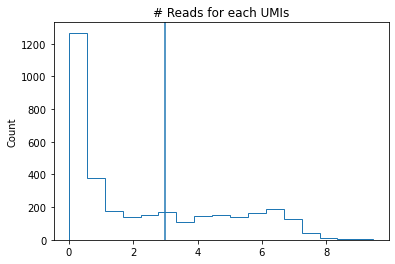

In [25]:
# should only be shRNA per UMI
print("By UMI/Cell")
_ = plt.hist(np.log2(histogram_of_UMIs), bins='auto', histtype='step')
plt.ylabel("Count")
plt.title("# Reads for each UMIs")
cutoff2 = 3
plt.axvline(x=cutoff2)
plt.show()

In [26]:
cutoff2 = 2**cutoff2
print(cutoff2)

8


In [27]:
## counting total UMIs from dominant shRNA
assignedCellshRNA = {}
assignedCellbarcode = {}
poorUMI = []
poorUMI2 = []
count = []
threshold = cutoff

for x in cellbyUMI:
    ncellbyUMI = {}
    for y in cellbyUMI[x]:
        UMIpairs = [(cellbyUMI[x][y][z],z) for z in cellbyUMI[x][y]] # stored as (count, (shRNAID,barcode))
        UMIpairs.sort(reverse=True)
        newUMI = []
        while len(UMIpairs) != 0:
            shRNAIDbarcodepair = UMIpairs.pop(0) #
            toDelete = []
            for z in range(0, len(UMIpairs)):
                if shRNAIDbarcodepair[1][0] != UMIpairs[z][1][0]: continue
                if hammingDistance(shRNAIDbarcodepair[1][1],UMIpairs[z][1][1]) <= 2:
                    toDelete.append(z)
                    shRNAIDbarcodepair = (shRNAIDbarcodepair[0]+UMIpairs[z][0],shRNAIDbarcodepair[1])
            newUMI.append(shRNAIDbarcodepair)
            for z in sorted(toDelete, reverse = True):
                del UMIpairs[z]

        if len(newUMI) == 1:
        # uncomment here if we don't want to ignore single counts
            if newUMI[0][0] >= threshold: ncellbyUMI[y] = newUMI[0][1]
            continue

        # Shouldn't happen anymore with the cleaned up version
        newUMI.sort(reverse=True)
        if newUMI[0][0] < threshold: continue
    
        totalUMI = sum([z[0] for z in newUMI])
        if scipy.stats.binom_test(newUMI[0][0], totalUMI, 1/len(newUMI), alternative='greater') <= 0.05:
            ncellbyUMI[y] = newUMI[0][1]   
        else:
            print("multiple: %s" % str(newUMI))
        #### end
        
    UMIpairs = {}

    if len(ncellbyUMI) == 0: 
        print("is zero")
        continue            
        
#    if len(ncellbyUMI) == 1:
#        continue
        # uncomment here if we don't want to ignore UMIs assigned by single counts
        #assignedCellshRNA[x] = list(ncellbyUMI.values())[0][0]
        #assignedCellbarcode[x] = list(ncellbyUMI.values())[0][1]
        #count.append(1)

        #adding single UMIs to poorUMI list instead of assigning label
#        poorUMI.append([(1,ncellbyUMI)])
#        poorUMI2.append(x)
#        continue

    for y in ncellbyUMI:   #ncellbyUMI[UMI] = (shRNAID, barcode)
        if ncellbyUMI[y] in UMIpairs:
            UMIpairs[ncellbyUMI[y]] += 1
        else:
            hamming=False
            for z in UMIpairs:  #instead of assigning this randomly I could order it by number of highest read counts
                if z[0] != ncellbyUMI[y][0]: continue
                if hammingDistance(ncellbyUMI[y][1], z[1]) <= 2:
                    UMIpairs[z] += 1
                    hamming=True
                    break
            if hamming: continue
            UMIpairs[ncellbyUMI[y]] = 1
    
#    if len(UMIpairs) == 0: 
#        print("UMIPairs")
#        print(ncellbyUMI)
#        print(cellbyUMI[x])
#        print("error this shoudl not happen")
#        continue

    if len(UMIpairs) == 1:
        if list(UMIpairs.values())[0] < cutoff2: 
            #print("Didn't pass cutoff2: %d, %s" % (cutoff2, str(UMIpairs)))
            continue
        assignedCellshRNA[x] = list(UMIpairs.keys())[0][0]
        assignedCellbarcode[x] = list(UMIpairs.keys())[0][1]
        count.append(list(UMIpairs.values())[0])
        continue        
    
    newUMI = [(UMIpairs[y], y) for y in UMIpairs]  # UMIpairs[(shRNAID, barcode)] = count
    newUMI.sort(reverse=True)
    if newUMI[0][0] < cutoff2: continue

    totalUMI = sum([y[0] for y in newUMI])
    count.extend([z[0] for z in newUMI])

    if scipy.stats.binom_test(newUMI[0][0], totalUMI, 1/len(newUMI), alternative='greater') <= 0.10:
        assignedCellshRNA[x] = newUMI[0][1][0]
        assignedCellbarcode[x] = newUMI[0][1][1]
        continue
#    else:
#        set_trace()
    poorUMI.append(newUMI)
    poorUMI2.append(x)

multiple: [(32, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (30, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (29, ('ACACGTGA', 'GGGGGAAGGGGGTTGTGGGAA')), (23, ('TGTCTAGT', 'CCCTCAACCGCCTTCCCCCAA')), (22, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (22, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (19, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (18, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA'))]
multiple: [(28, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (24, ('GCCTACGT', 'GGGGGAAGGGGGTTGGGGGAA')), (22, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
multiple: [(26, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (26, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (24, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (23, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (19, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (19, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (18, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (18, ('CGGGAATG', 'TTCTCAACGCCTTTTTCCCAA'))]
multiple: [(29, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (25, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (22, ('TGTC

multiple: [(27, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (23, ('TTAATTAG', 'TTTTTAATTTTTTTTTTTTAA')), (22, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (21, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA')), (19, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (17, ('GCCTACGT', 'GGGGGAAGGGGGTTGGGGGAA'))]
multiple: [(26, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (21, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA'))]
multiple: [(32, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (30, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (19, ('TTAATTAG', 'TTTTTAATTTTTTTTTTTTAA')), (17, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA'))]
multiple: [(27, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (26, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (26, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (19, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (18, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
multiple: [(31, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (29, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (25, ('TGTCTAGT', 'TTTTTAATTTTTTTTTTTTAA')), (21, ('TGTCTAGT', 'GGGGGAATGGGGTTGGGGGAA')), 

multiple: [(19, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (18, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
multiple: [(28, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (21, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (18, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
multiple: [(22, ('CGGGAATG', 'GTATGAAAGCCTTTTTTGGAA')), (17, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
multiple: [(27, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (22, ('TGTCTAGT', 'TTTTTAATTTCTTTGGTTTAA')), (19, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
multiple: [(27, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (25, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
multiple: [(26, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (18, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA'))]
multiple: [(30, ('TGTCTAGT', 'GGGGGAAGGAAGTTGGGGGAA')), (26, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (26, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
multiple: [(19, ('TGTCTAGT', 'GGGGTAAGGAGGTTGGGGGAA')), (19, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
multiple: [(29, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (

multiple: [(24, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA')), (18, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
multiple: [(18, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (18, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
multiple: [(39, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (33, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (33, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (26, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (22, ('GCCTACGT', 'TCCTTAAGTGGATTGGTTCAA'))]
multiple: [(26, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (20, ('CTGAATCT', 'ACAAAAAAATAATTTAAAAAA')), (20, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
multiple: [(31, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (29, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (27, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (27, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (20, ('TTAATTAG', 'TTTTAAATATTTTTCTTTTAA')), (19, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (17, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (17, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA'))]
multiple: [(19, ('CGGGAATG', 'CCCCCAACCCCCTTC

multiple: [(28, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (26, ('TTAATTAG', 'TCCCTAAAATCCTTCCATCAA')), (23, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (20, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (17, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
multiple: [(24, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (18, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
multiple: [(27, ('CGTTTCCT', 'AGAGAAAATAAGTTGTTCGAA')), (23, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (18, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
multiple: [(25, ('CGTTTCCT', 'AGAGAAACTAAGTTGTTCGAA')), (17, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
multiple: [(21, ('ACACGTGA', 'TTTTTAATTTTTTTTTTTTAA')), (20, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
multiple: [(19, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (18, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA'))]
multiple: [(25, ('ACAGAGCC', 'TACGCAATCGAGTTTACCTAA')), (19, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
multiple: [(30, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (28, ('ACAGAGCC', 'ACGATAATGAGTTTTACTAAA')), (26, ('GCCTA

multiple: [(24, ('CGGGAATG', 'CTCTTAACACCTTTATATCAA')), (23, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (22, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
multiple: [(19, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (17, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA'))]
multiple: [(20, ('ACAGAGCC', 'GCTTTAATGTTGTTATTAAAA')), (18, ('ACAGAGCC', 'GCTTGAATTTTGTTATGAAAA'))]
multiple: [(28, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA')), (24, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
multiple: [(25, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (24, ('TGTCTAGT', 'CACCCAACTCCATTTCATCAA')), (18, ('TGTCTAGT', 'GGGCGAAGGGGGTTGGGGGAA')), (17, ('TTAATTAG', 'TTTTTAATTTTTTTTTTTTAA'))]
multiple: [(23, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (19, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
multiple: [(26, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (25, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (25, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (25, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (24, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (22, ('TGTCTAGT', 'TATT

multiple: [(18, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (17, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
multiple: [(24, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (23, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (21, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
multiple: [(24, ('CGGGAATG', 'CCCTCAATCGTTTTCTACCAA')), (19, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA'))]
multiple: [(20, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (20, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
multiple: [(21, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (19, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA'))]
multiple: [(31, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (30, ('ACAGAGCC', 'AGAAGAACTAGATTGCCACAA')), (17, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (17, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
multiple: [(19, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (18, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (18, ('ACAGAGCC', 'AGAAGAACTAGATTGCCACAA'))]
multiple: [(21, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (19, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
multiple: [(

multiple: [(31, ('ACAGAGCC', 'TCGTTAACAGCGTTTTGCTAA')), (19, ('TGTCTAGT', 'TTTTTAATTTCTTTTTTTTAA'))]
multiple: [(27, ('CGTTTCCT', 'GGTCTAAGATAGTTGGGTTAA')), (17, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
multiple: [(24, ('CGTTTCCT', 'GGTCTAAGATAGTTGGGTTAA')), (23, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (21, ('CGGGAATG', 'GGGGGAAGGGGGTTGGGGGAA'))]
multiple: [(24, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (18, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (17, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
multiple: [(18, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (17, ('TTAATTAG', 'TTTTTAATTTTTTTTTTTTAA'))]
multiple: [(18, ('TGTCTAGT', 'ATTACAACTGGTTTGTTGTAA')), (18, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
multiple: [(31, ('TGTCTAGT', 'ATTACAACTGGTTTGTTGTAA')), (27, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (20, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (17, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
multiple: [(20, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (17, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
multiple: [(

multiple: [(19, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (18, ('CTGAATCT', 'CCCCCAAACCCATTCCCCCAA'))]
multiple: [(23, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (18, ('GCCTACGT', 'GGGGGAAGGGGGTTAGGGGAA')), (18, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
multiple: [(27, ('ACACGTGA', 'CCCCCAATGCCATTCCCCCAA')), (25, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (20, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (19, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
multiple: [(29, ('ACACGTGA', 'CCCCCAATGCAATTCCCCCAA')), (19, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA'))]
multiple: [(24, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (20, ('ACACGTGA', 'TGTTTAATTTTTTTTTCTGAA')), (18, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA'))]
multiple: [(27, ('GGTAGGGA', 'AGAGAAAAGTGTTTGCTTAAA')), (22, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (20, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (19, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA'))]
multiple: [(17, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (17, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
multiple: [(27, ('CGGGA

multiple: [(27, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (20, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (18, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA'))]
multiple: [(27, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (25, ('CGGGAATG', 'TTCTCAACGCCTTTTTACCAA')), (20, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (17, ('ACACGTGA', 'GGGGGAAGGGGGTTGTGGGAA'))]
multiple: [(26, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (18, ('TGTCTAGT', 'GTAGGAATTTTTTTGGGGTAA')), (17, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
multiple: [(27, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (19, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
multiple: [(25, ('CCATTACT', 'ACGTTAATAGTATTACGTAAA')), (23, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (23, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (18, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (17, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
multiple: [(22, ('CGGGAATG', 'GGGAGAAGGGTGTTGGGGGAA')), (20, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
multiple: [(21, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (19, ('GCCTACGT', 'TCCT

multiple: [(25, ('CGGGAATG', 'TTGTGAATTGTTTTGGGTGAA')), (25, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (25, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (20, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA'))]
multiple: [(19, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (18, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (17, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (17, ('CGGGAATG', 'TTTTGAATTGTTTTGGGTGAA'))]
multiple: [(21, ('ACACGTGA', 'GGGGGAAGGGGATTGGAGCAA')), (20, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (19, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (19, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
multiple: [(23, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (17, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (17, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
multiple: [(21, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (19, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
multiple: [(28, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (20, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (20, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA'))]
multiple: [(24, ('GCCAATCG', 'CACA

multiple: [(21, ('ACACGTGA', 'GGGGGAAGGGGGTTGTGGGAA')), (19, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA'))]
multiple: [(30, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (26, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA')), (22, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (22, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (22, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (22, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA')), (19, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (17, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA'))]
multiple: [(35, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (31, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (31, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (19, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
multiple: [(21, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA')), (20, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (19, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
multiple: [(24, ('CGGGAATG', 'GGGGGAAGGGGGTTGGGGGAA')), (19, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (17, ('TGTCTAGT', 'TTTTTAATTTCTTTTTTTTAA'))]
multiple: [(28, ('TGTCTAGT', 'CCCCCAACCCCCTTC

multiple: [(28, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (28, ('ACAGAGCC', 'TGAATAAATATCTTAAAATAA')), (27, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (19, ('TGTCTAGT', 'GGGCGAAGGGGGTTGGGGGAA'))]
multiple: [(20, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (17, ('TGTCTAGT', 'CCCCCAACCCCCTTCTCCCAA'))]
multiple: [(23, ('CTGAATCT', 'CCCCCAAACCCATTCCCCCAA')), (23, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (20, ('TGTCTAGT', 'TTTTCAATTTCCTTCCTCTAA')), (18, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (17, ('ACACGTGA', 'TTTTTAATTTTTTTTTTTTAA'))]
multiple: [(29, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (18, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
multiple: [(23, ('CTGAATCT', 'CCCCCAACCCCTTTCCCCCAA')), (17, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA'))]
multiple: [(27, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (26, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA'))]
multiple: [(33, ('TTAATTAG', 'TTTTTAATTTTTTTCTTTTAA')), (26, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (19, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
multiple: [(22, ('CAGTG

multiple: [(25, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (19, ('CTGAATCT', 'CCCCCAAACCCATTCCCCCAA'))]
multiple: [(19, ('TTAATTAG', 'AAAAGAAGAAAGTTGAAAAAA')), (19, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (17, ('GTACTTGC', 'GTTAAAAGGAAATTGTACGAA'))]
multiple: [(33, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (31, ('GCCTACGT', 'GGGGGAAGGGGGTTAGGGGAA')), (27, ('ACACGTGA', 'TTTTTAATTTTTTTTTTTTAA')), (25, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (23, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (23, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (19, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (19, ('CTGAATCT', 'ACAACAAAAACCTTTAAACAA'))]
multiple: [(26, ('TGTCTAGT', 'TTTTTAATTTTTTTTTTTTAA')), (25, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (24, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (17, ('TGTCTAGT', 'TATTTAATTTCCTTTGTTTAA')), (17, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
multiple: [(24, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (22, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA'))]
multiple: [(27, ('GCCTACGT', 'TCCTTAAGTGGTTTG

multiple: [(20, ('TGTCTAGT', 'GGGGGAAGGGGATTGGGGGAA')), (17, ('CGGGAATG', 'AGCCCAACCCCCTTCCCCCAA'))]
multiple: [(28, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (19, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (17, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA'))]
multiple: [(30, ('GCCTACGT', 'GGGGGAAGGGGGTTGGGGGAA')), (30, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (26, ('GCCTACGT', 'TCCTTAAGTGGTTTGGTTCAA')), (21, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (21, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (20, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (18, ('TTAATTAG', 'TTTTTAATTTTTTTTTGTTAA')), (18, ('GCCTACGT', 'AGGTGAACTGCGTTGGGAAAA')), (18, ('CGTTCAAG', 'TATTCAAATATCTTGGTATAA'))]
multiple: [(24, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (20, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
multiple: [(20, ('TGTCTAGT', 'TTTTTAATTTCTTTTTTTTAA')), (19, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA')), (18, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
multiple: [(30, ('CGGGAATG', 'CCCCCAACCCCCTTCCCCCAA')), (23, ('CAGTGCAT', 'GTGGAAATTTTATTG

multiple: [(31, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (28, ('TGTCTAGT', 'CCCCCAACCCCCTTCCTCCAA')), (25, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (21, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA'))]
multiple: [(25, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (22, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (18, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (17, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA'))]
multiple: [(28, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (21, ('TGTCTAGT', 'GGGGGAAGGGGGTTGGGGGAA')), (20, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA'))]
multiple: [(23, ('CAGTGCAT', 'GTGGAAATTTTATTGGTAGAA')), (20, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA'))]
multiple: [(22, ('TGTCTAGT', 'CCCCCAACCCCCTTCCCCCAA')), (21, ('GCCAATCG', 'CACATAAGAACCTTCATTGAA')), (17, ('TGTCTAGT', 'TATTTAATTTCTTTTGTTTAA')), (17, ('ACAGAGCC', 'GCTTTAATTTTGTTATTAAAA'))]
multiple: [(29, ('ACACGTGA', 'TGTTTAAGTTTTTTTTTTGAA')), (22, ('CGGGAATG', 'GGGGGAAGGGGGTTGGGGGAA')), (22, ('CGGGAATG', 'CCCCCAACCCCCTTCCGTCAA')), (19, ('CAGTGCAT', 'GTGGAAATTTTATTG

In [28]:
import statistics
sum(count)/len(count), min(count), max(count), statistics.median(count)

(34.14697265625, 1, 707, 13.0)

By UMI/Cell


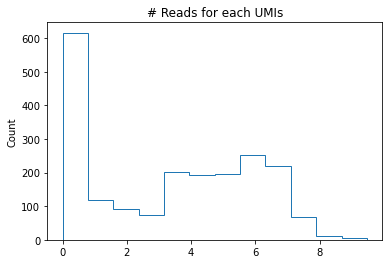

In [29]:
# should only be shRNA per UMI
print("By UMI/Cell")
_ = plt.hist(np.log2(count), bins='auto', histtype='step')
plt.ylabel("Count")
plt.title("# Reads for each UMIs")
plt.show()

In [30]:
len(assignedCellshRNA)

1163

In [31]:
len(whitelist)

7114

In [32]:
#count.sort()
#count

In [33]:
len(poorUMI)

1

In [34]:
poorUMI

[[(19, ('TGTCTAGT', 'TTTTTAATTTTTTTTTTTTAA')),
  (15, ('ACAGAGCC', 'ACTGGAAACCATTTGAATAAA'))]]

In [35]:
#calculate average hammandDistance
hdist = []
for x in poorUMI:
    if len(x) == 1:
#        hdist.append(0)
        continue
    y = [(z[1][0], z[1][1]) for z in x]
    pUMI = {}
    for z in y:
        if z[0] not in pUMI:
            pUMI[z[0]] = [z[1]]
        else:
            pUMI[z[0]].append(z[1])
    for y in pUMI:
        if len(pUMI[y]) < 2:
            continue
        for i in range(0, len(pUMI[y])):
            for j in range(i+1, len(pUMI[y])):
                hdist.append(hammingDistance(pUMI[y][i], pUMI[y][j]))
                if hammingDistance(pUMI[y][i], pUMI[y][j]) == 2:
                    print(pUMI[y])
                    print(pUMI[y][i], pUMI[y][j])

    

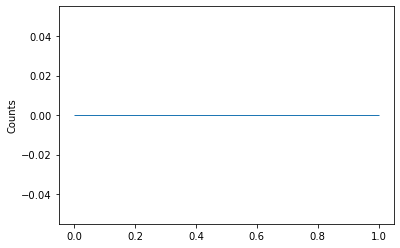

In [36]:
_ = plt.hist(hdist, bins='auto', histtype='step')

plt.ylabel("Counts")
plt.show()

#assign shRNA to barcodes with same shRNA virus
for x in range(len(poorUMI)):
    y = [z[1][0] for z in poorUMI[x]]
    if len(set(y)) == 1:
        assignedCellshRNA[poorUMI2[x]] = y[0]
        assignedCellbarcode[poorUMI2[x]] = "NA"

In [37]:
validshRNANameHash = {}
for x in assignedCellshRNA:
    validshRNANameHash[x] = hashes[assignedCellshRNA[x]]

In [38]:
len(assignedCellbarcode)

1163

In [39]:
import pandas as pd
pUMI = {}
for x in poorUMI2:
    pUMI[x] = 1
cellhashobj = pd.DataFrame.from_dict(pUMI, orient='index')
cellhashobj.rename(columns={0: "pUMI"}, inplace=True)
cellhashobj.to_pickle('pUMIcDNA.pickle')

In [40]:
import pandas as pd
  
cellhashobj = pd.DataFrame.from_dict(validshRNANameHash, orient='index')
cellhashobj.rename(columns={0: "shRNA"}, inplace=True)
cellhashobj.to_pickle('shRNAcDNA.pickle')

cellhashobj = pd.DataFrame.from_dict(assignedCellbarcode, orient='index')
cellhashobj.rename(columns={0: "barcode"}, inplace=True)
cellhashobj.to_pickle('barcodecDNA.pickle')

## END CODE HERE FOR NOW